In [1]:
from requests.packages import target
# from xgboost.dask import predict

import CONSTANTS
from functions import *
import warnings
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformer_classes import *
from tqdm import tqdm
from sklearn.metrics import *

warnings.filterwarnings('ignore')

# Transformer

Objective: predict change in BTC price given features

## Prepare data
Create tupled dataset


In [2]:
data = pd.read_csv(f'../{fullDataPath('BTC')}')
data['gradient'] = data['close'].diff().fillna(0.0)
data

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,date,link,text,sentiment,score,gradient
0,2024-06-10,69141.51,70187.53,69641.08,69497.73,6088.403632,-143.35,-0.205841,64462.8325,63358.5884,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,0.00
1,2024-06-11,66018.69,69547.82,69495.97,67316.53,17354.689155,-2179.44,-3.136067,64121.3590,63292.0274,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-2181.20
2,2024-06-12,66883.32,70032.00,67316.52,68248.60,17140.011394,932.08,1.384623,63897.0390,63237.8892,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,932.07
3,2024-06-13,66200.00,68474.49,68248.59,66738.85,11916.132111,-1509.74,-2.212119,63586.6200,63178.6808,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-1509.75
4,2024-06-14,65005.00,67322.72,66746.46,66004.39,11520.157919,-742.07,-1.111774,63256.9280,63072.2650,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-734.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,2025-06-05,100345.73,105999.68,104753.37,101570.20,10615.733871,-3183.17,-3.038728,75487.7350,67144.2722,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,-3183.18
433,2025-06-06,101132.91,105439.01,101570.20,104397.99,9674.999986,2827.79,2.784074,73498.7105,66428.7766,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,2827.79
434,2025-06-07,103969.70,106000.00,104398.00,105619.02,4141.101243,1221.02,1.169582,71319.6450,65699.2984,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,1221.03
435,2025-06-08,105028.30,106548.90,105619.02,105784.40,1998.610110,165.38,0.156582,69119.4635,64944.9062,...,0.0,0.0,0.0,-,NaN,-,-,-,0.0,165.38


In [3]:
# Convert time to datetime if it's not already
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])

# Extract date component
data['date'] = data['time'].dt.date

# Group by date and aggregate values (one row per day)
# Hard coded change later
daily_data = (
    data
    .groupby('date')
    .agg(
        close=('close', 'last'),  # Take the last close price of the day
        avg_sentiment=('score', 'mean'),  # Average sentiment for the day
        tweet_count=('score', 'count'),   # Number of observations per day
        gradient=('gradient', 'last'),     # Take the last gradient of the day
        volume=('volume', 'last'),          # Total volume for the day
        BB_Lower=('BB_Lower', 'last'),  # Last value of BB lower band
        BB_Middle=('BB_Middle', 'last'),  # Last value of BB middle band
        BB_Upper=('BB_Upper', 'last'),  # Last value of BB upper band
        SMA_20=('SMA_20', 'last'),  # Last value of SMA 20
        SMA_50=('SMA_50', 'last'),  # Last value of SMA 50
        Volume_MA_20=('Volume_MA_20', 'last'),  # Last value of Volume MA 20
        
    )
    .reset_index()
)

# Convert date back to datetime format if needed
daily_data['time'] = pd.to_datetime(daily_data['date'])
daily_data = daily_data.drop('date', axis=1)

# Sort by time
daily_data = daily_data.sort_values('time')
daily_data.set_index('time', inplace=True)
daily_data

,close,avg_sentiment,tweet_count,gradient,volume,BB_Lower,BB_Middle,BB_Upper,SMA_20,SMA_50,Volume_MA_20
time,,,,,,,,,,,
2024-06-10,69497.73,0.0,1,0.00,6088.403632,58918.218171,64462.8325,70007.446829,64462.8325,63358.5884,10009.565107
2024-06-11,67316.53,0.0,1,-2181.20,17354.689155,59062.416571,64121.3590,69180.301429,64121.3590,63292.0274,9918.306387
2024-06-12,68248.60,0.0,1,932.07,17140.011394,59040.832267,63897.0390,68753.245733,63897.0390,63237.8892,9666.907278
2024-06-13,66738.85,0.0,1,-1509.75,11916.132111,59123.849377,63586.6200,68049.390623,63586.6200,63178.6808,9344.338774
2024-06-14,66004.39,0.0,1,-734.46,11520.157919,58800.431456,63256.9280,67713.424544,63256.9280,63072.2650,9351.868007
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,101570.20,0.0,1,-3183.18,10615.733871,40026.834262,75487.7350,110948.635738,75487.7350,67144.2722,8963.375612
2025-06-06,104397.99,0.0,1,2827.79,9674.999986,39777.796875,73498.7105,107219.624125,73498.7105,66428.7766,9192.668042
2025-06-07,105619.02,0.0,1,1221.03,4141.101243,40498.165922,71319.6450,102141.124078,71319.6450,65699.2984,9278.557960


<Axes: title={'center': 'BTC Price'}, xlabel='Date', ylabel='Price (USD)'>

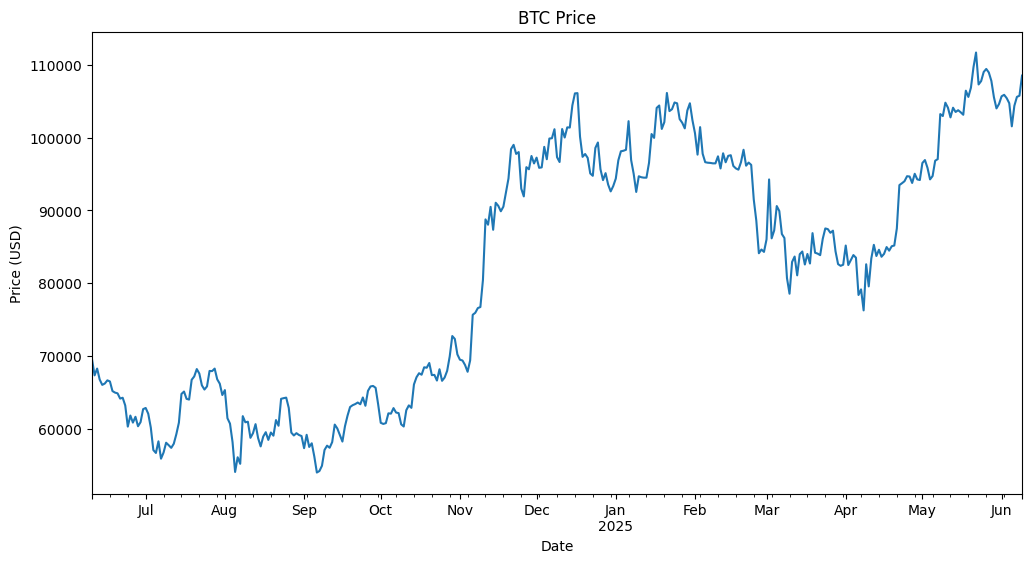

In [4]:
daily_data['close'].plot.line(title=f'{COIN} Price', figsize=(12, 6), ylabel='Price (USD)', xlabel='Date')

<Axes: ylabel='Frequency'>

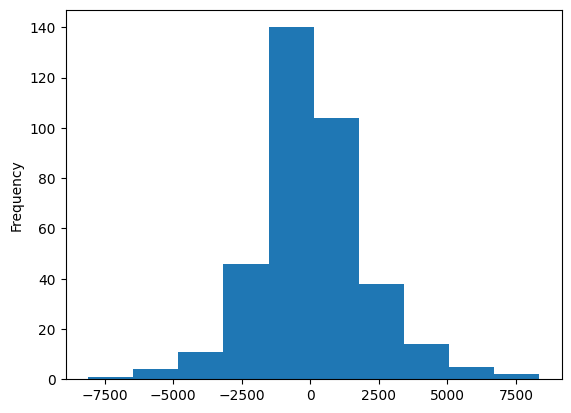

In [5]:
daily_data['gradient'].plot.hist()

In [6]:
daily_data['close'].describe()

count       365.000000
mean      81652.222877
std       17204.605933
min       53950.010000
25%       64179.630000
50%       84183.420000
75%       96903.190000
max      111722.530000
Name: close, dtype: float64

# Load the Transformer Model

Sequence the data to make it predict the next price

## Preprocess the data


In [7]:
seqs = []
nexts = []
for i in range(len(daily_data)):
    try:
        seq, next = sequence(daily_data['close'], i)
        seqs.append(seq)
        nexts.append(next)
    except Exception as e:
        print(f'Error at {i} Exception:', e)
        
seqs = [padding(seq, len(daily_data)) for seq in seqs]
daily_data['sequence'] = seqs
daily_data['next'] = nexts
daily_data[['sequence', 'next']].head(10)

,sequence,next
time,,
2024-06-10,"[-99999999.0, -99999999.0, -99999999.0, -99999...",67316.53
2024-06-11,"[69497.73, -99999999.0, -99999999.0, -99999999...",68248.60
2024-06-12,"[69497.73, 67316.53, -99999999.0, -99999999.0,...",66738.85
2024-06-13,"[69497.73, 67316.53, 68248.6, -99999999.0, -99...",66004.39
2024-06-14,"[69497.73, 67316.53, 68248.6, 66738.85, -99999...",66192.00
2024-06-15,"[69497.73, 67316.53, 68248.6, 66738.85, 66004....",66628.75
2024-06-16,"[69497.73, 67316.53, 68248.6, 66738.85, 66004....",66481.81
2024-06-17,"[69497.73, 67316.53, 68248.6, 66738.85, 66004....",65152.80
2024-06-18,"[69497.73, 67316.53, 68248.6, 66738.85, 66004....",64943.79


## Load the Model

### Data Setup

In [8]:
testSize = len(daily_data)-30
train_data = daily_data.iloc[:testSize]
test_data = daily_data.iloc[testSize:]
test_data.index.min(), test_data.index.max()

(Timestamp('2025-05-11 00:00:00'), Timestamp('2025-06-09 00:00:00'))

In [9]:
X_train = train_data[['sequence']]
y_train = train_data['next']
X_test = test_data[['sequence']]
y_test = test_data['next']

In [10]:
from sklearn.preprocessing import StandardScaler

# Create scalers for both sequences and targets
sequence_scaler = StandardScaler()
target_scaler = StandardScaler()

# Normalize target values (Bitcoin close prices)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Normalize sequences (assuming they also contain price data)
def normalize_sequences(df_column, scaler):
    normalized_sequences = []
    for seq in df_column:
        # Convert list to array and normalize
        seq_array = np.array(seq).reshape(-1, 1)
        normalized_seq = scaler.fit_transform(seq_array).flatten()
        normalized_sequences.append(normalized_seq.tolist())
    return normalized_sequences

# Apply normalization to your sequence data
X_train_norm = pd.DataFrame({
    'sequences': normalize_sequences(X_train.iloc[:, 0], sequence_scaler)
})
X_test_norm = pd.DataFrame({
    'sequences': normalize_sequences(X_test.iloc[:, 0], sequence_scaler)
})

# Convert to pandas Series
y_train_norm = pd.Series(y_train_scaled)
y_test_norm = pd.Series(y_test_scaled)

In [11]:
model = torch.load(f'../models/{COIN}_model.pth')

Data shapes - X: torch.Size([335, 365, 1]), y: torch.Size([335, 1])
DataFrame column: sequences
Sample sequence length: 365


Training Progress: 100%|██████████| 400/400 [2:09:05<00:00, 19.36s/it]   

Training completed!


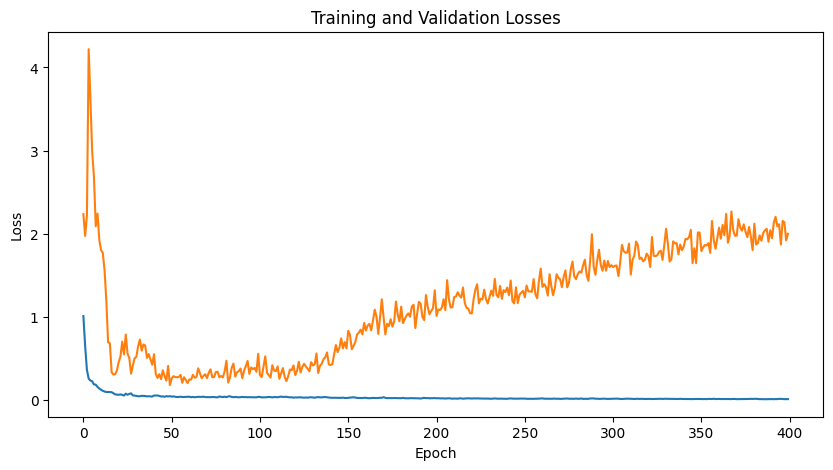

In [12]:
# Create model with appropriate settings for Bitcoin prediction
model = BaseTransformer(
    d_model=128,
    num_heads=8,
    num_layers=4,
    learning_rate=1e-4,  # This is fine now with normalized data
    batch_size=32,
    dropout=0.1,
    mask_value=FILL
)
model.fit(X_train_norm, y_train_norm, epochs=400, validation_data=(X_test_norm, y_test_norm))
torch.save(model, f'../models/{COIN}_model.pth')

In [17]:
predictions = model.predict(X_test_norm)
predictions = target_scaler.inverse_transform(predictions).reshape(-1)
predictions = pd.Series(predictions, index=y_test.index)
y_test_norm.index = X_test_norm.index

rmse = root_mean_squared_error(y_test, predictions)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 23028.6634


<Axes: title={'center': 'Difference on Prediction and Actual'}, xlabel='time'>

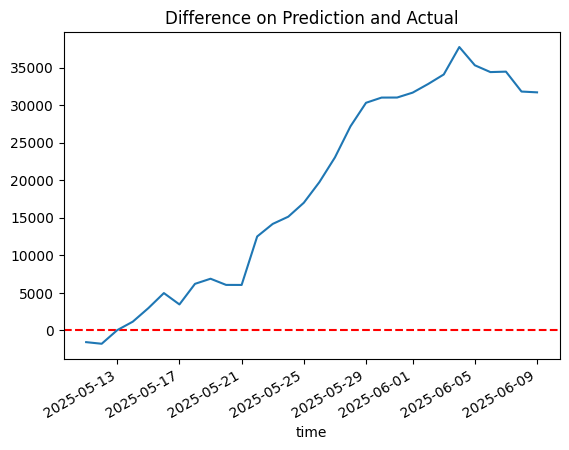

In [18]:
diff = predictions - y_test
plt.axhline(0.0, color='r', linestyle='--')
diff.plot.line(title='Difference on Prediction and Actual')

<Axes: title={'center': 'Predicted vs. Actual Value on Validation Month'}, xlabel='Date', ylabel='Price'>

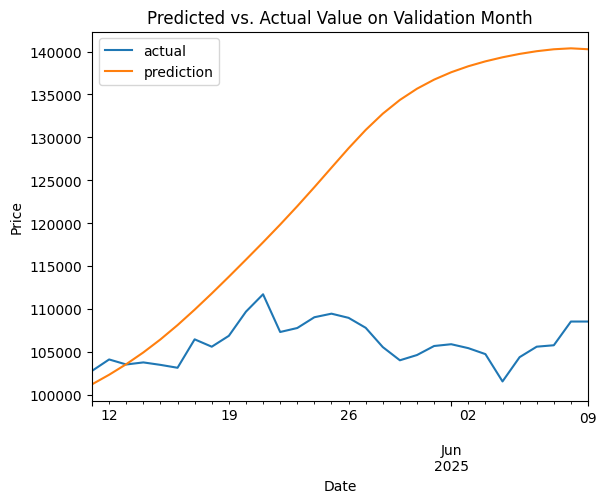

In [15]:
comparison = pd.concat([y_test, predictions], axis=1)
comparison.columns = ['actual', 'prediction']
comparison.plot.line(title='Predicted vs. Actual Value on Validation Month', xlabel='Date', ylabel='Price')

In [22]:
def predict_sequence(model, last_price, sequence_length=30, total_length=365):
    """
    Generate a sequence of predictions autoregressively
    
    Args:
        model: Your trained transformer
        initial_price: The last known Bitcoin price
        sequence_length: How many future prices to predict
        total_length: Total input length (365 in your case)
    """
    
    # Start with the initial price
    current_sequence = [last_price]
    
    # Generate predictions one by one
    for i in range(sequence_length):
        # Create input array: current sequence + padding
        input_data = padding(current_sequence, target_length=total_length)
        
        # Create DataFrame for model input
        input_df = pd.DataFrame({'sequences': [input_data]})
        
        # Get next prediction
        next_prediction = model.predict(input_df)[0][0]  # Extract scalar value
        next_prediction = target_scaler.inverse_transform([[next_prediction]])[0][0]
        
        # Add prediction to sequence
        current_sequence.append(next_prediction)
    
    return current_sequence

# Usage
last_known_price = y_test.values[-1]  # Your last known Bitcoin price
n = 1
predicted_sequence = predict_sequence(model, sequence_length=n)

print(f"Starting price: ${last_known_price:.2f}")
print(f"{n}-day predicted sequence: {predicted_sequence}")

Starting price: $108547.24
1-day predicted sequence: [103422.03717090543]


In [ ]:
for i in range(1):
    predicted_seq = predict_sequence(model, sequence_length=30)